# Extension to the digits classification

Try to extract the digits from a picture.
Assume that the picture contains only digits for now.
Use scikit-image for this to stay in the same framework.
Start with loading the relevant modules and the picture.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import ndimage as ndi
from skimage.io import imread
from skimage import data
from skimage.filters import threshold_otsu, rank
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.util import img_as_ubyte
from skimage.transform import downscale_local_mean
from skimage import measure, filters
from skimage.filters import threshold_otsu, threshold_adaptive

from sklearn import datasets
from pylab import plt, np
from sklearn import svm

%matplotlib inline

In [14]:
im = imread('my_digits/my_digits_3.jpg')

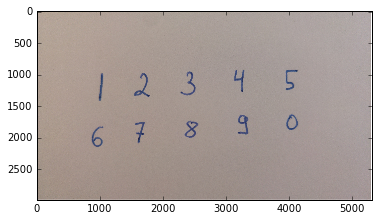

In [15]:
plt.imshow(im, cmap='gray_r', interpolation='none')

In [16]:
image = np.mean(im, axis=2)
image = image / np.max(image) * 256
image = np.max(image) - image
# scale down
image = downscale_local_mean(image, (5, 5))
# image_downscaled = image

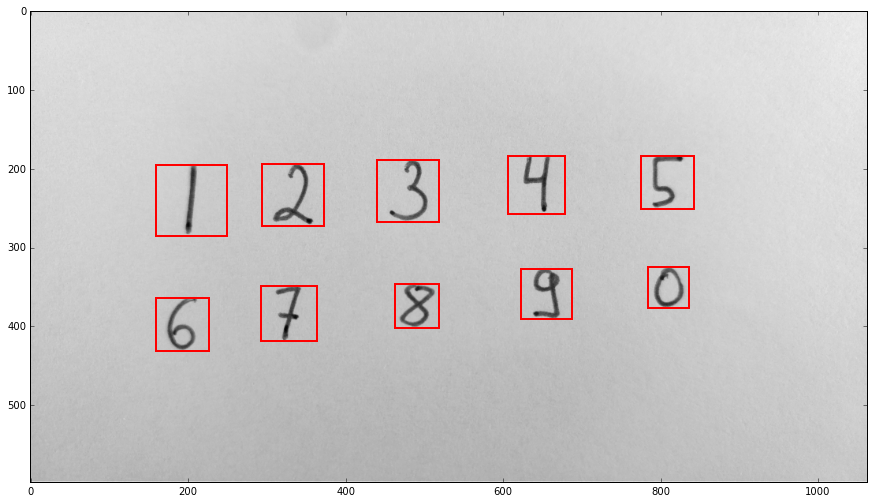

In [17]:
# image = image_downscaled
global_thresh = threshold_otsu(image)
binary_global = image > global_thresh
binary_global = closing(binary_global, square(4))
# fill holes
bw = ndi.binary_fill_holes(binary_global)
cleared = bw.copy()
clear_border(cleared)
# label image regions
label_image = label(cleared)
plt.figure(figsize=(15,10))
# plt.imshow(im_gauss)
plt.imshow(image, cmap='gray_r')
for region in regionprops(label_image):
    # skip small images
#     if region.area < 100:
#         continue
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    # make regions square
    maxwidth = np.max([maxr - minr, maxc - minc])
    minr, maxr = int(0.5 * ((maxr + minr) - maxwidth)) - 1, int(0.5 * ((maxr + minr) + maxwidth)) + 1
    minc, maxc = int(0.5 * ((maxc + minc) - maxwidth)) - 1, int(0.5 * ((maxc + minc) + maxwidth)) + 1
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
plt.show()

# Build the classifier

In [18]:
%matplotlib inline
digits = datasets.load_digits()
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(digits.data[:-1], digits.target[:-1])  

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

Apply to identified regions.

In [19]:
from scipy.misc import imresize
from sklearn.datasets.base import Bunch
size = (8, 8)

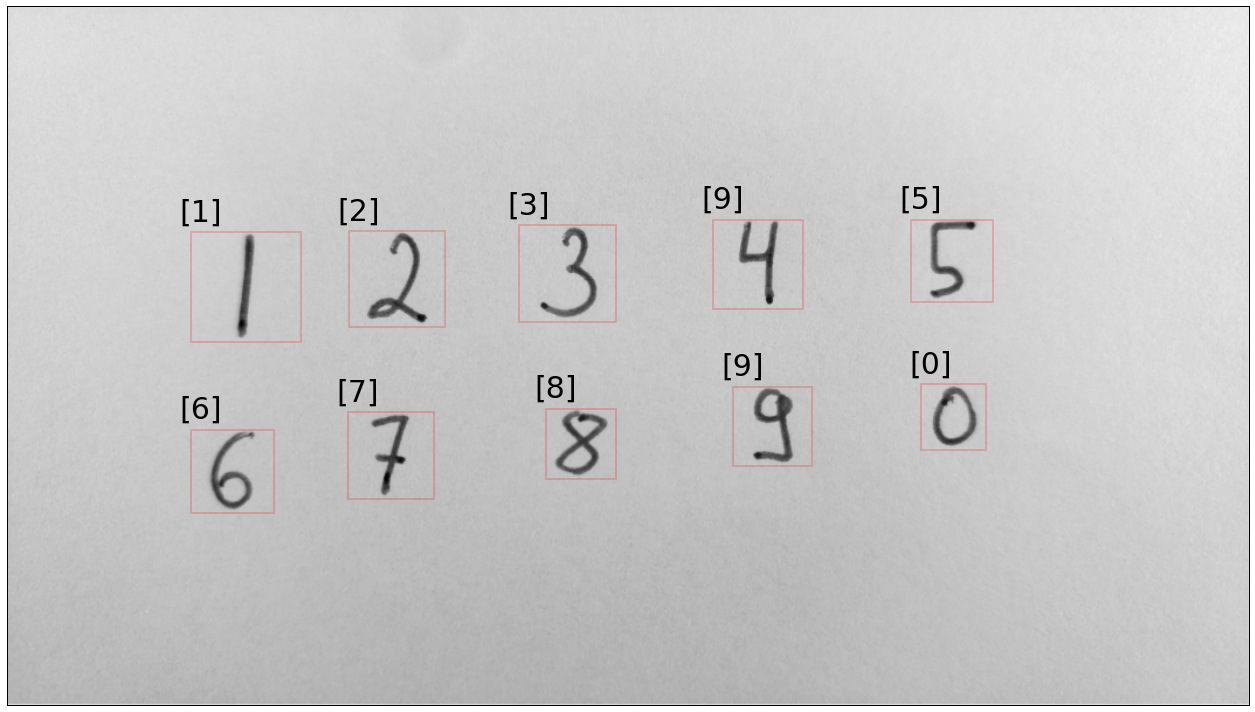

In [20]:
plt.figure(figsize=(20, 10))
plt.imshow(image, cmap='gray_r')
for region in regionprops(label_image):
    # skip small images
#     if region.area < 100:
#         continue
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    # make regions square
    maxwidth = np.max([maxr - minr, maxc - minc])
    minr, maxr = int(0.5 * ((maxr + minr) - maxwidth)) - 3, int(0.5 * ((maxr + minr) + maxwidth)) + 3
    minc, maxc = int(0.5 * ((maxc + minc) - maxwidth)) - 3, int(0.5 * ((maxc + minc) + maxwidth)) + 3
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2, alpha=0.2)
    plt.gca().add_patch(rect)
    # predict digit
    candidate = image[minr:maxr, minc:maxc]
    candidate = np.array(imresize(candidate, size), dtype=float)
    # invert
    # candidate = np.max(candidate) - candidate
    #     print im
    # rescale to 16 in integer
    candidate = (candidate - np.min(candidate))
    if np.max(candidate) == 0:
        continue
    candidate /= np.max(candidate)
    candidate[candidate < 0.2] = 0.0
    candidate *= 16
    candidate = np.array(candidate, dtype=int)
    prediction = clf.predict(candidate.reshape(-1))
    plt.text(minc - 10, minr -10 , "{}".format(prediction), fontsize=30)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.show()